# Basis functions
In this notebook we bring in the idea of basis functions, and see how piecewise regression can be seen as linear modelling.

The focus of this notebook is to explore the concepts... the code is not meant to be a neat generalized solution to running piecewise/basis regression models at this point.

In [1]:
using Distributions, Plots, StatsBase, StatsPlots, Turing

<div class="alert alert-block alert-warning">
<b>FYI:</b> When we run Bayesian inference below, we will attempt to run mulitple chains in parallel. Below we check how many threads we have access to.
</div>

In [2]:
n_chains = Threads.nthreads()
print(n_chains)

8

## Create some data

In [3]:
n_observations = 100

f(x) = 0 -2(x/30) -1(x/30)^2 + 4(x/30)^3;
x = sort(rand(Uniform(-30, 30), n_observations))
y = f.(x) + randn(length(x))*0.25;

Create some knots. Just like in previous notebooks, we are treating these as fixed (as opposed to free) parameters in the model. They are defined by uniformly spacing them along the ordered $x$ values.

In [4]:
k = percentile(x, [20, 40, 60, 80])
print(k)

[-15.974952860121792, -2.0336738236661, 6.299569004173571, 18.639594306400234]

Visualise the data and the knots.

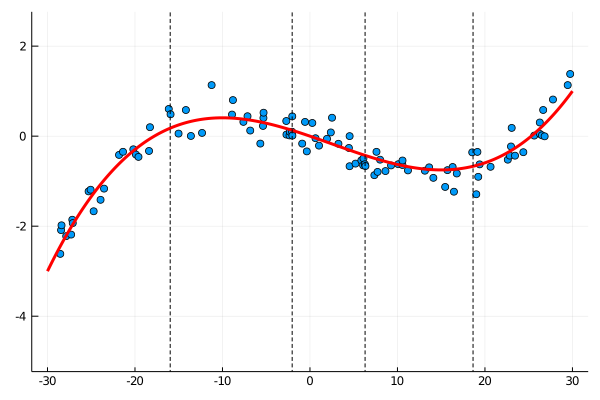

In [5]:
function plot_data(x, y)
    scatter(x, y, label="data")
    xi = [-30:0.01:30;]
    plot!(xi, f.(xi), label="true", lw=3, color=:red)
    plot!(legend=false)
end

function plot_knots(k)
    vline!(k, color=:black, linestyle=:dash)
    plot!(ylim=(minimum(y)*2, maximum(y)*2))
end

plot_data(x, y)
plot_knots(k)

## Basis functions for piecewise constant regression
This next function is going to take a vector of knots and return a vector of functions which compute the basis functions.

In [6]:
function make_constant_bases(k)
    @assert length(k)>2
    temp = []
    # deal with first segment
    append!(temp, [x -> 1])
    append!(temp, [x -> x≤k[1] ? 1 : 0])
    # middle segments
    for i in 1:length(k)-1
        append!(temp, [x -> k[i]<x≤k[i+1] ? 1 : 0])
    end
    # final segment
    append!(temp, [x -> x>k[end] ? 1 : 0])
end

constant_basis_functions = make_constant_bases(k);

We can visualise what these basis functions look like.

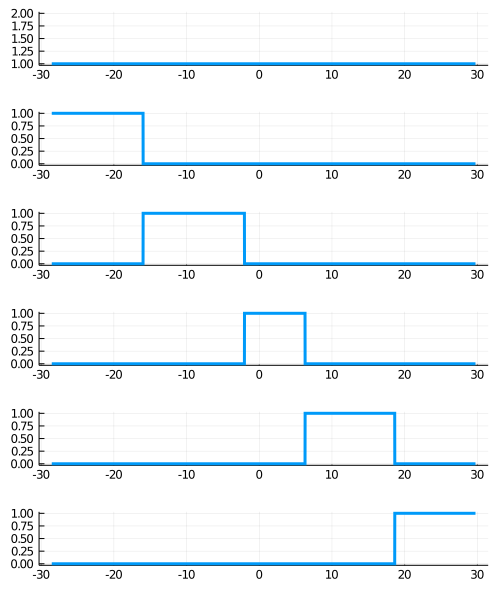

In [7]:
function plot_basis_functions(basis_functions, xi)
    n_basis_functions = length(basis_functions)
    xi = LinRange(minimum(x), maximum(x), 5000)
    plot(layout=(n_basis_functions,1), size=(500, 600))
    for i in 1:n_basis_functions
        plot!(xi, basis_functions[i].(xi), subplot=i, legend=false, lw=3)
    end
    plot!()
end

xi = LinRange(-35, 35, 500)

plot_basis_functions(constant_basis_functions, xi)

Now we can create a design matrix $X$. Each row will be an observation. Each column will correspond to a basis vector

In [8]:
function design_matrix(x, basis_functions)
    n_observations = length(x)
    n_basis_funcs = length(basis_functions)
    X = zeros(Float64, (n_observations, n_basis_funcs))
    
    for row in 1:n_observations
        for basis in 1:n_basis_funcs
            X[row, basis] = basis_functions[basis](x[row])
        end
    end
    return X
end

design_matrix (generic function with 1 method)

In [9]:
X = design_matrix(x, constant_basis_functions)

100×6 Array{Float64,2}:
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0

Now we can just calculate the estimated $y$ values by $y^{est} = X \cdot \beta$. For the moment we will use random set of parameters.

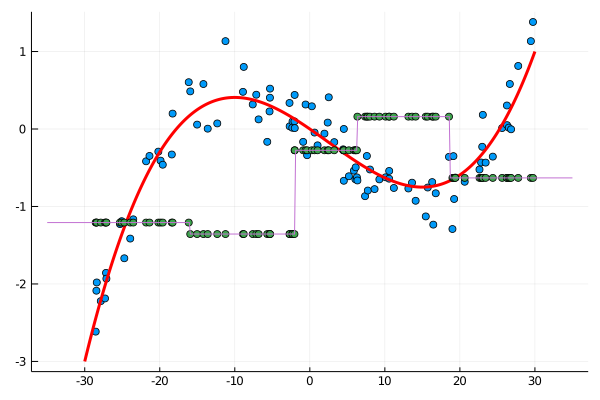

In [10]:
plot_data(x, y)

# random weight vector
β = rand(Normal(0, 1), length(constant_basis_functions))
y_est = X * β
scatter!(x, y_est, legend=false)

# interpolation
plot!(xi, design_matrix(xi, constant_basis_functions) * β)

## Bayesian parameter estimation

So now we have the piecewise constant regression model formulated as a linear model. We've just used a set of basis functions in order to generate a design matrix. So we should be able to proceed and esimate the parameters of our linear model.

In [11]:
@model function linear_model(X, y)
    n_obs, n_bases = size(X)
    β ~ filldist(Normal(0, 1), n_bases)
    σ ~ truncated(Normal(0, 2), 0, Inf)
    μ = X * β
    @. y ~ Normal(μ, σ)
end;

In [12]:
chains = sample(linear_model(X, y), NUTS(), MCMCThreads(), 1000, n_chains)

┌ Info: Found initial step size
│   ϵ = 0.366796875
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Tur

Chains MCMC chain (1000×19×8 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6, 7, 8
Samples per chain = 1000
parameters        = β[1], β[2], β[3], β[4], β[5], β[6], σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        β[1]   -0.3113    0.4041     0.0045    0.0113   1366.5147    1.0035
        β[2]   -0.8272    0.4160     0.0047    0.0113   1437.6299    1.0035
        β[3]    0.6065    0.4163     0.0047    0.0116   1420.9301    1.0031
        β[4]    0.1456    0.4175     0.0047    0.0114   1442.6501    1.0034
        β[5]   -0.4103    0.4167     0.0047    0.0114   1451.3219    1.0030
        β[6]    0

If you want to visualise the chains, you can do that simply with:

```julia
plot(chains)
```

Next we'll visualise the posterior predictive fits in data space

In [13]:
function plot_posterior_predictive(chains, basis_functions)
    # extract info from chains
    β1 = vec(chains["β[1]"])
    β2 = vec(chains["β[2]"])
    β3 = vec(chains["β[3]"])
    β4 = vec(chains["β[4]"])
    β5 = vec(chains["β[5]"])
    β6 = vec(chains["β[6]"])
    
    # plot a limited set of samples
    subsamples = 100
    ind = rand(1:length(β1), subsamples)
    for i in ind
        β = vec([β1[i] β2[i] β3[i] β4[i] β5[i] β6[i]])
        # linear model
        yi = design_matrix(xi, basis_functions) * β  
        plot!(xi, yi, color=:black, alpha=0.1)
    end
    # to make the plot appear
    plot!()
end;

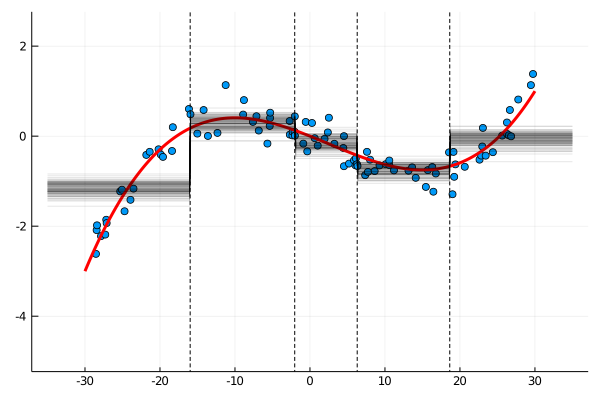

In [14]:
plot_data(x, y)
plot_knots(k)
plot_posterior_predictive(chains, constant_basis_functions)

## Piecewise linear regression
Now let's do the same for piecewise linear regression

In [15]:
function make_linear_bases(k)
    @assert length(k)>2
    temp = []
    # deal with first segment
    append!(temp, [x -> 1])
    append!(temp, [x -> x])
    # remaining segments
    for i in 1:length(k)
        append!(temp, [x -> T(x, k[i])])
    end
    return temp
end

T(x, k) = (x-k)*(x≥k);

linear_basis_functions = make_linear_bases(k);

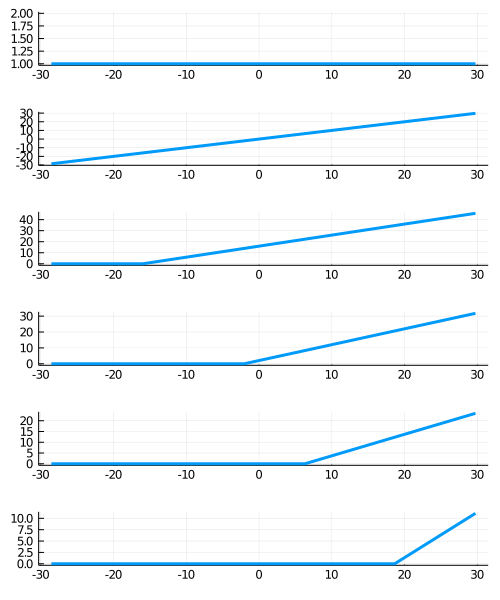

In [16]:
plot_basis_functions(linear_basis_functions, xi)

Note to self: If you want to introduce a discontinuity on purpose, then you can do something like this:

```julia
function make_linear_bases_with_discontinuity(k)
    @assert length(k)>2
    temp = []
    # deal with first segment
    append!(temp, [x -> 1])
    append!(temp, [x -> x])
    # middle segments
    for i in 1:length(k)-1
        append!(temp, [x -> T(x, k[i])])
    end
    # final segment
    append!(temp, [x -> x>k[end] ? 1 : 0])
    return temp
end
```

This will put a discontinuity beteween the last segment and the rest. This could be useful in certain contexts.

In [17]:
X = design_matrix(x, linear_basis_functions)

100×6 Array{Float64,2}:
 1.0  -28.5399  -0.0     -0.0     -0.0     -0.0
 1.0  -28.4462  -0.0     -0.0     -0.0     -0.0
 1.0  -28.3956  -0.0     -0.0     -0.0     -0.0
 1.0  -27.8587  -0.0     -0.0     -0.0     -0.0
 1.0  -27.2978  -0.0     -0.0     -0.0     -0.0
 1.0  -27.1628  -0.0     -0.0     -0.0     -0.0
 1.0  -27.1122  -0.0     -0.0     -0.0     -0.0
 1.0  -25.3011  -0.0     -0.0     -0.0     -0.0
 1.0  -25.0714  -0.0     -0.0     -0.0     -0.0
 1.0  -24.724   -0.0     -0.0     -0.0     -0.0
 1.0  -23.9352  -0.0     -0.0     -0.0     -0.0
 1.0  -23.5333  -0.0     -0.0     -0.0     -0.0
 1.0  -21.8213  -0.0     -0.0     -0.0     -0.0
 ⋮                                          ⋮
 1.0   23.0571  39.0321  25.0908  16.7575   4.41752
 1.0   23.4319  39.4069  25.4656  17.1323   4.79231
 1.0   24.3869  40.3619  26.4206  18.0874   5.74733
 1.0   25.6318  41.6068  27.6655  19.3322   6.99222
 1.0   26.2684  42.2434  28.3021  19.9689   7.62883
 1.0   26.283   42.258   28.3167  19.9834   7.

In [18]:
chains = sample(linear_model(X, y), NUTS(), MCMCThreads(), 1000, n_chains)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ A

Chains MCMC chain (1000×19×8 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6, 7, 8
Samples per chain = 1000
parameters        = β[1], β[2], β[3], β[4], β[5], β[6], σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        β[1]    3.7187    0.2633     0.0029    0.0049   2634.8011    1.0003
        β[2]    0.2062    0.0116     0.0001    0.0002   2732.9197    1.0003
        β[3]   -0.2205    0.0191     0.0002    0.0004   2421.5967    1.0005
        β[4]   -0.0782    0.0202     0.0002    0.0004   2642.7998    1.0010
        β[5]    0.0594    0.0207     0.0002    0.0003   3143.6855    1.0012
        β[6]    0

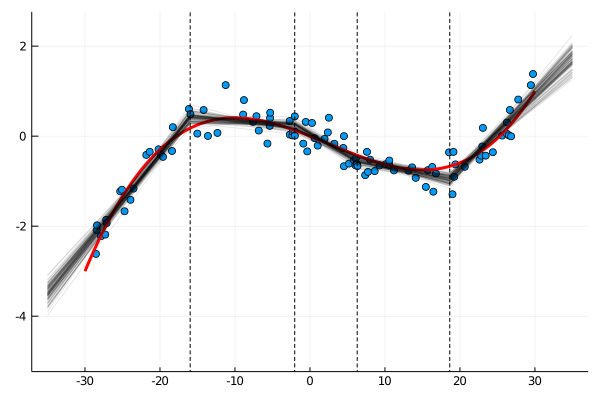

In [19]:
plot_data(x, y)
plot_knots(k)
plot_posterior_predictive(chains, linear_basis_functions)

## Piecewise cubic regression
So now we'll move on to cubic regression